# Gender By Names

## Imports

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## Exploratory Data Analysis 


In [6]:
df = pd.read_csv("/kaggle/input/gender-by-name/data.csv")

df['Name'] = df['Name'].str.lower().str.strip()

df['Gender'] = df['Gender'].map({'F': 0, 'M': 1})

df = df.drop_duplicates(subset=['Name'])

df = df.dropna(subset=['Name', 'Gender'])

print(df.shape)
print(df.head())
print(df['Gender'].value_counts())


(133910, 4)
      Name  Gender    Count  Probability
0    james       1  5304407     0.014517
1     john       1  5260831     0.014398
2   robert       1  4970386     0.013603
3  michael       1  4579950     0.012534
4  william       1  4226608     0.011567
Gender
0    83326
1    50584
Name: count, dtype: int64


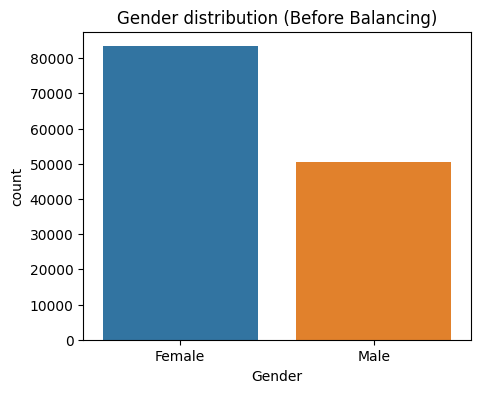

In [12]:
plt.figure(figsize=(5,4))
sns.countplot(x=df['Gender'])
plt.title("Gender distribution (Before Balancing)")
plt.xticks([0,1], ['Female','Male'])
plt.savefig("gender_distribution_before.png", dpi=300, bbox_inches='tight')
plt.show()

## Balancing the dataset

In [8]:
from sklearn.utils import resample

df_female = df[df['Gender'] == 0]
df_male   = df[df['Gender'] == 1]

df_female_down = resample(df_female,
                          replace=False,    
                          n_samples=len(df_male),
                          random_state=42)

df_balanced = pd.concat([df_female_down, df_male])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(df_balanced['Gender'].value_counts())

Gender
1    50584
0    50584
Name: count, dtype: int64


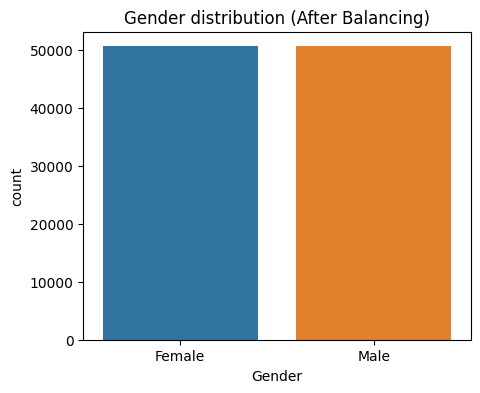

In [13]:
plt.figure(figsize=(5,4))
sns.countplot(x=df_balanced['Gender'])
plt.title("Gender distribution (After Balancing)")
plt.xticks([0,1], ['Female','Male'])
plt.savefig("gender_distribution_after.png", dpi=300, bbox_inches='tight')
plt.show()

## Data Preprocessing

In [16]:
all_text = " ".join(df_balanced['Name'].values)
chars = sorted(list(set(all_text)))
print("Unique characters:", chars)
print("Vocabulary size:", len(chars))

char2idx = {c: i+1 for i, c in enumerate(chars)}
idx2char = {i: c for c, i in char2idx.items()}

Unique characters: [' ', "'", '(', ')', ',', '-', '.', '/', '0', '1', '5', '7', '8', '9', ';', '?', '@', '[', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'à', 'ö', 'œ', '…']
Vocabulary size: 48


In [17]:
def name_to_seq(name):
    return [char2idx[c] for c in name if c in char2idx]

df_balanced['Seq'] = df_balanced['Name'].apply(name_to_seq)

print(df_balanced[['Name', 'Seq']].head())

        Name                                   Seq
0  jabraylin  [28, 19, 20, 36, 19, 43, 30, 27, 32]
1     danyea              [22, 19, 32, 43, 23, 19]
2     gernie              [25, 23, 36, 32, 27, 23]
3      jireh                  [28, 27, 36, 23, 26]
4   airazona      [19, 27, 36, 19, 44, 33, 32, 19]


In [18]:
max_len = max(df_balanced['Seq'].apply(len))
print("Max name length:", max_len)
 
X = pad_sequences(df_balanced['Seq'], maxlen=max_len, padding='post')
 
y = df_balanced['Gender'].values

print("X shape:", X.shape)
print("y shape:", y.shape)

Max name length: 25
X shape: (101168, 25)
y shape: (101168,)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

Train size: 80934
Test size: 20234


## Model Architecture

In [21]:
vocab_size = len(char2idx) + 1  
embedding_dim = 64
lstm_units = 128

model = Sequential([
    Embedding(input_dim=vocab_size, 
              output_dim=embedding_dim, 
              input_length=max_len),
    Bidirectional(LSTM(lstm_units, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')   
])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.build(input_shape=(None, max_len))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 25, 64)         │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 217,281 (848.75 KB)

 Trainable params: 217,281 (848.75 KB)

 Non-trainable params: 0 (0.00 B)

## Training


In [25]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "best_gender_name_lstm.h5",   
    monitor='val_loss',            
    save_best_only=True,           
    verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=25,
    batch_size=128,
    callbacks=[early_stop, checkpoint],
    verbose=1
)


Epoch 1/25
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8631 - loss: 0.3327
Epoch 1: val_loss improved from inf to 0.33629, saving model to best_gender_name_lstm.h5
506/506 ━━━━━━━━━━━━━━━━━━━━ 45s 90ms/step - accuracy: 0.8631 - loss: 0.3327 - val_accuracy: 0.8577 - val_loss: 0.3363
Epoch 2/25
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8670 - loss: 0.3203
Epoch 2: val_loss improved from 0.33629 to 0.33072, saving model to best_gender_name_lstm.h5
506/506 ━━━━━━━━━━━━━━━━━━━━ 46s 91ms/step - accuracy: 0.8670 - loss: 0.3203 - val_accuracy: 0.8632 - val_loss: 0.3307
Epoch 3/25
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8693 - loss: 0.3184
Epoch 3: val_loss improved from 0.33072 to 0.32450, saving model to best_gender_name_lstm.h5
506/506 ━━━━━━━━━━━━━━━━━━━━ 47s 93ms/step - accuracy: 0.8693 - loss: 0.3184 - val_accuracy: 0.8658 - val_loss: 0.3245
Epoch 4/25
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8738 - loss: 0.3092
Epoch 4: val_loss im

## Plotting

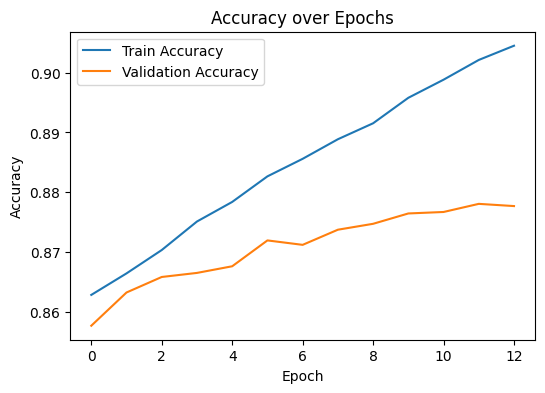

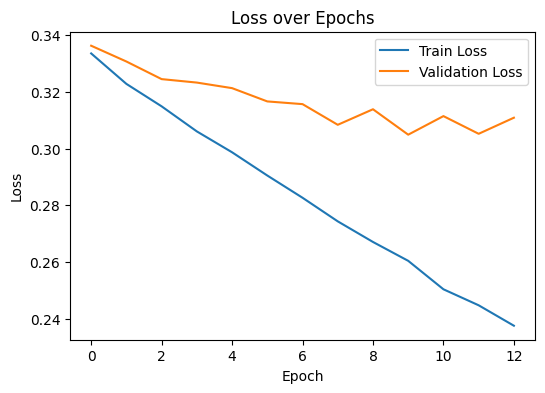

In [26]:
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("accuracy_plot.png", dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("loss_plot.png", dpi=300, bbox_inches='tight')
plt.show()